In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt
from tqdm import tqdm
from IPython.core.debugger import set_trace


import warnings
warnings.filterwarnings("ignore")

## 1. Loading data, visulization

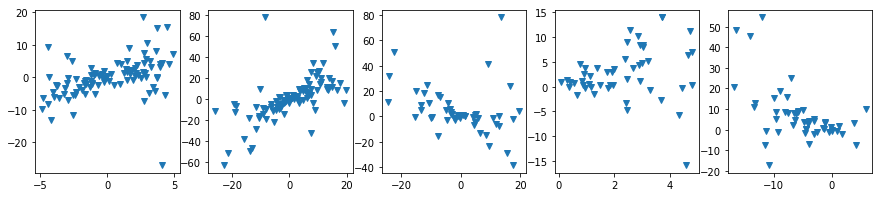

In [2]:
fn = []
_, ax = plt.subplots(1, 5, figsize=[15, 3])
ax = ax.ravel()
da = []

for k, axk in enumerate(ax):
    fn.append('data_1_' + str(k+1) + '.csv')
    data = pd.read_csv(fn[-1])
    axk.plot(data['x'], data['y'], 'v')
    
    da.append(data)
    

## 2. Data has very high tail noise

## 3. Using Bayesian treatment for linear regression
Ref[1]: Christopher Bishop, Cazhaow S. Qazaz, "Regression with Input-Dependent Noise: A Baysian Treatment", Advances in Neural Information Processing Systems, Jan. 1997

### 3.1 Model 

As the noise is input depent, the goal is to predict both a regression function and an input-dependent noise variance. We shall therefore consider, two networks. The first network takes the input x and generates an output  y(x,ω) , which is governed by a vector of weight parameters ω . The second network also takes the input x, and generates an output function  $β(x,\mu)$ representing the inverse variance of the noise distribution, and is governed by a vector of weight parameters μ . The conditional distribution of target data at given x has a mean error of zero, is then modelled by a normal distribution $p(y|x,w,\mu)=N(y_n|x,ω,β)$.

From this we obtain the likelihood function
$$p(D|\omega, \mu) = \frac{1}{Z_D}\exp\{\sum_{n=1}^N \beta_n E_n\}$$
where $\beta_n = \beta(x_n,\mu), Z_D = \Pi_{n=1}^N (\frac{2\pi}{\beta_n})^\frac{1}{2}, E_n = \frac{1}{2}[y(x_n,\omega) - y_n]^2$

### 3.2 $\beta$ function

According to Ref[1], with basis function for $\beta$ is set to $x^m, m = 0, 1, 2, ...$, the $\beta$ function is 
$$\beta(x,\mu) = \exp{\sum_{m=0}^M \mu_m x^m}$$

In [9]:
# beta funtion
# noise inverse variance, 

def noise_inv_var(x, mu=[0., 0., 0.]):
    ''' x: data, shape = [n, ], float
        mu: parameters of noise inverse variance, shape = [m, ], float
        return: noise inverse variance, shape = [n, ], float
    '''
    
    btop = 0
    for m, u in enumerate(mu):
        btop = btop + u*x**m        
    
    return np.exp(btop)

# En
# error of fitting
def Enerr(x, y, w=[0, 1]):
    ''' x: input data, shape = [n, ], float
        y: output data, shape = [n, ], float
        w: linear fitting coefs, shape = [2, ], float        
        return: error = 1/2(y_fit - y)**2, shape = [n, ], flaot
    '''
    
    y_fit = w[0] + w[1]*x
    return 1/2*(y_fit - y)**2

### 3.3 Loss functions 

According to Ref[1], with maximum likelihood function, the loss functions for $\omega$ and $\mu$ are respectively
$$S(\omega) = \sum_{n=1}^N \beta_n E_n + \frac{\alpha_\omega}{2}||\omega||$$
$$M(\mu) = \sum_{n=1}^N \beta_n E_n + \frac{\alpha_\mu}{2}||\mu|| - \frac{1}{2}\ln|A|$$
where $\alpha_\omega, \alpha_\mu$ are hyperparameters and given fixed before linear regression, |A| denotes the determinant of the Hessian matrix and with the linear regression given by
$$|A| = (\sum_{n=1}^N \beta_n + \alpha_\omega)(\sum_{n=1}^N \beta_n x_n^2 + \alpha_\omega) - (\sum_{n=1}^N \beta_n x_n)^2$$

$\omega$ and $\mu$ are then solved by minimize the above loss functions, the gradient of |A| to $\mu_m$ is also needed and given by 


$$\frac{d|A|}{d\mu_m} = (\sum_{n=1}^N \beta_n x_n^m + \alpha_\omega)(\sum_{n=1}^N \beta_n x_n^2 + \alpha_\omega) + (\sum_{n=1}^N \beta_n + \alpha_\omega)(\sum_{n=1}^N \beta_n x_n^{(2+m)} + \alpha_\omega) - 2(\sum_{n=1}^N \beta_n x_n)(\sum_{n=1}^N \beta_n x_n^{m+1})$$.




### 3.4 Quality function

The reduced $\chi^2_r$ function is used to qualify the linear estimation.

### 3.5 Algorithm

step:0 generate data sets from a given data file for linear regression, where 20% of data sets is used for training and rest for testing.

step1: set the order of $\mu$ (i.e: number of parameters for $\mu$) and inithilize $\mu$ to 0, fixed $\alpha_\omega, \alpha_\mu$

step2: finding $\omega$ by minimize $S(\omega)$ with given $\mu$

step3: finding $\mu$ by minimize $M(\mu)$ with given $\omega$. (Here optimization module from scipy is using for the step).

step4: repeat step2 and step3 untill the differece of $\omega$ for the last two iteration below tolerance

step5: output $\omega$ and $\mu$

step6: calculate quality function with the test data sets

In [10]:
# loss function for u

def M_u(mu, x, y, w, au, aw):
    '''
    x: float, input data, shape = [n, ]
    y: float, shape = [n, ]
    w: linear coefficients, shape = [2, ]
    au, aw: hyperparamters
    return: S_u, shape = [1, ]
    '''
    
    B, Hm, detA, detA_mu, beta = detA_dmu(x, y, mu, aw)
    En = Enerr(x, y, w)
    
    Su = (beta*En).sum() + 0.5*au*(mu**2).sum() - 0.5*np.log(beta).sum() + 0.5*np.log(detA)    
    return Su

# Jacobian of loss function M_u, gradient of M_u to u
# needed in optimization to get u
def Jac_M_u(mu, x, y, w, au, aw):
    '''
    return d(M(u))/du
    '''
    
    B, Hm, detA, detA_mu, beta = detA_dmu(x, y, mu, aw)
    En = Enerr(x, y, w)
    
    jac = []
    for m in range(len(mu)):
        jac.append(au*mu[m] + 0.5*detA_mu[m]/detA + np.sum(beta*En*x**m - 0.5*x**m))
    
    return np.asarray(jac)
    

# serach mu by scipy.opt.minimize
def u_by_MAP(mu, x, y, w, au, aw, bds=(-10, 10), tol=1e-5):
    '''
    bds: bounds for mu
    tol: toleration for mu
    return: mu
    '''
      
    bds = [bds]*len(mu)        
    
    res = opt.minimize(M_u, mu, (x, y, w, au, aw), method='TNC', bounds=bds, jac=Jac_M_u, options={'xtol':tol})   
    
    if res.success:
        return res.x
    else:
        # search failed and zeroing mu for research
        mu = np.zeros(mu.shape)
        return mu

In [12]:
# Hessian matrix and its associations

def detA_dmu(x, y, mu, aw):
    '''x: input data, shape = [n, ], float
       y: output data, shape = [n, ], float
       mu: parameters of noise inverse variance, shape = [m, ], float       
       aw: hyperparameter for w
       return: B, Offset array for w from function S(w)
               A, Hessian matrix, shape = [2, 2],
               detA, Hessian matrix determinant, shape = [1],
               detA_mu, dervation of Hessian matrix determinant to mu, shape = [len(mu), ]
               beta, noise inverse variance shape = [n, ]
    '''
    beta = noise_inv_var(x, mu)
    
    beta_xm  = []
    for m in range(len(mu)):
        beta_xm.append(beta*(x**m))
    
    Hm = np.array([[beta.sum()  + aw, beta_xm[1].sum()], [beta_xm[1].sum(), beta_xm[2].sum() + aw]]) # Hessian matrix
    
    detA = np.linalg.det(Hm) # determinant of Hm
    detA_mu =[]
    
    for m in range(len(mu)):
        
        Bm = beta_xm[m].sum()*Hm[1,1] + \
             Hm[0, 0]*(beta_xm[m]*x**2).sum() - \
             2*(beta_xm[m]*x).sum()*beta_xm[1].sum()
        
        detA_mu.append(Bm)
        
    B = np.array([(beta*y).sum(), (beta*y*x).sum()])
        
    return B, Hm, detA, np.array(detA_mu), beta
    

In [13]:
# search for w and mu based on maximum likelihood propability to minimize S(w) and M(u)

def wmu_by_MLF(x, y, u_order=2, au=0.1, aw=0.1, mit=1000, tol=1e-3):
    '''x: input data, shape = [n, ], float
       y: output data, shape = [n, ], float
       u_order: order of mu, ie how many parameters in mu
       mit: maxmimum iteration for search
       tol: tolerance of w
       return: w, linear fit coefs, shape = [2, 1], float
               mu, 
    '''
    
    # initialize mu and w
    mu = np.zeros(u_order+1)
    w = np.polyfit(x, y, 1)[::-1]    
    
    mu_s = []    
    w_s = []
    
    mu_s.append(mu.copy())
    w_s.append(w.copy())
    
    nn = 0
    nFlag = True
    
    while nn < mit and nFlag:
        
        mm = 0 # iteration for mu
        mFlag = True
        
        # solving w by matrix operation
        B, Hm, detA, detA_mu, beta = detA_dmu(x, y, mu, aw)
        w = np.linalg.inv(Hm)@B
        
        # solving u by scipy optimization
        mu = u_by_MAP(mu, x, y, w, au, aw)
        
        # error w for the last iteration
        err_w = np.abs((w_s[-1] - w)/(w + 1e-9)).sum()
        
        if (err_w > tol or nn == 0): 
            nn = nn + 1
            mu = (mu_s[-1] + mu)/2
                        
            mu_s.append(mu.copy())
            w_s.append(w.copy())
            
        else:
            nFlag = False
            
    return not(nFlag), w_s, mu_s
        

In [15]:
# generate data sets

def Gen_samples(dlen, slen=30, Ns=100):
    '''
    generate data sets
    dlen: maximum input data length, int
    slen: sample data length, int
    Ns: number of samples, int
    return: index array of data sets
    '''
    
    np.random.seed(10)
    
    return np.random.randint(0, dlen, size=[Ns, slen])
    

In [16]:
# goodness of fit, reduced chi-square

def r_chi_sq(sigma2, err2, dof):
    '''
    sigma2: variance of noise, shape = [n, ]
    err2: square of fitting error, (y_fit - y_obsevation)**2, shape = [n, ]
    dof: degree of freedom, fitting freedom = n_data_points - n_fit_parametrs
    return: reduced chi_square, > 1 poor fit, ~ 1 good fit, < 1 over fit    
    '''
    
    return((err2/sigma2/dof).sum())
    
    

### 3.6 Results with order of $\mu$ equals 2

 20%|████████▌                                  | 1/5 [02:37<10:30, 157.55s/it]

Bad model of beta function!!


 40%|█████████████████▏                         | 2/5 [05:49<08:23, 167.94s/it]

Bad model of beta function!!


 80%|██████████████████████████████████▍        | 4/5 [11:19<02:46, 166.75s/it]

Bad model of beta function!!


100%|███████████████████████████████████████████| 5/5 [13:38<00:00, 158.38s/it]


fiting coefficients:
           File         a         b
0  data_1_1.csv  0.073666  1.095808
1  data_1_2.csv -0.335933  1.279740
2  data_1_3.csv  0.848200 -0.638153
3  data_1_4.csv  0.340056  1.021892
4  data_1_5.csv  0.442133 -0.814673
fiting quality:
[1.17943806 1.63336565 1.66461846 1.33211478 1.64625497]


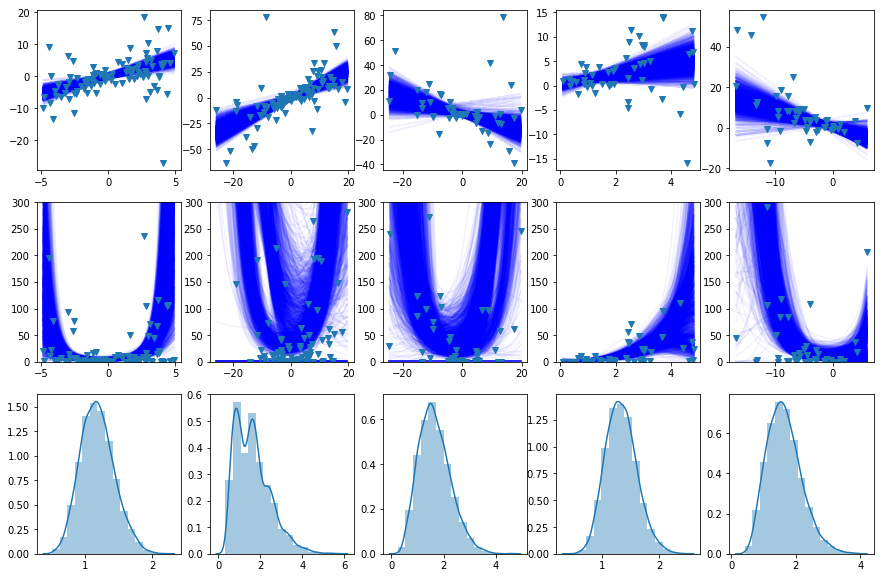

In [34]:
# generate Ns data sets, train on 20% and test on 80%

Ns =10000 # data sets
nTrain = int(Ns*0.2)

daFit = [] # final fitting results of all 5 files
fitQ = [] # fit quatlity of test data sets

_, axes = plt.subplots(3, 5, figsize=(15, 10))

for col, data in enumerate(tqdm(da)):
    w = []
    mu = []
    fitQ_d = []
    
    x = data['x'].values
    y = data['y'].values
    
    xp = np.linspace(x.min(), x.max(), 100)
    
    slen = int(len(x)*0.8) # 80% of data points    
    sid = Gen_samples(len(x), slen, Ns) # shape = [Ns, slen]

    # training to get w and mu
    for sk in sid[:nTrain]:
        success, w_s, mu_s = wmu_by_MLF(x[sk], y[sk], u_order=2, au=0.1, aw=0.1)
        if success:
            w.append(w_s[-1])
            mu.append(mu_s[-1])
            
            # plots fiting, variance, qulatiy
            axes[0, col].plot(x, w[-1][0] + w[-1][1]*x, '-b', alpha=0.05)
            axes[1, col].plot(xp, 1/noise_inv_var(xp, mu[-1]), '-b', alpha=0.05)            
    
    # check if all training are ok
    if len(w) < nTrain:
        print('Bad model of beta function!!')
        
            
    mu = np.asarray(mu).mean(axis=0)
    w = np.asarray(w).mean(axis=0)    
    
    # qulality of fitting based on reduced_chi function     
    dof = slen - len(w) - len(mu) -2# 2 for au and aw 
    for sk in sid[nTrain:]:
        sigma2 = 1/noise_inv_var(x[sk], mu)
        err2 = (y[sk] - w[0] - w[1]*x[sk])**2
        fitQ_d.append(r_chi_sq(sigma2, err2, dof))
    
    daFit.append([w, mu])
    fitQ.append(np.asarray(fitQ_d))
    
    axes[0, col].plot(x, y, 'v')
    axes[1, col].plot(x, 2*Enerr(x, y, w),'v')
    axes[1, col].set_ylim(0, 300)
    sns.distplot(fitQ_d, bins=15, kde=True, ax=axes[2, col])
    


fitQ = np.asarray(fitQ)
# output results to file

ab = np.vstack(daFit_k[0] for daFit_k in daFit) # fit parameters, y = ax + b
fitres = pd.DataFrame({'File': fn, 'a':ab[:,0],'b':ab[:,1]})
fitres.to_csv('submit.csv',index=False)

########
print('fiting coefficients:')
print(fitres)

print('fiting quality:')
print(fitQ.mean(axis=1))


## end--------------

### 3.7 Summary
The fitting results based on qulity estimation suggest that the model works fine. One could also try to invesigate how fitting quality varies with order of $\mu$, hyperparamters and even the basis funtion of $\beta$.